In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [22]:
# Import Data
assets = ['ZECUSDT', 'XMRUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['log_price'] = prices[asset]['price'].apply(lambda x: math.log(x))
    prices[asset]['returns'] = prices[asset]['price'].pct_change().fillna(0)
    prices[asset]['log_returns'] = prices[asset]['log_price'].pct_change().fillna(0)
    

## Utilities Functions

In [75]:
def set_same_length(df1, df2):
    # Set data same length
    if len(df1) > len(df2):
        diff = len(df1) - len(df2)
        df1 = df1[diff:]
    elif len(df1) < len(df2):
        diff = len(df2) - len(df1)
        df2 = df2[diff:]
    else:
        pass
    
    return df1, df2

def rolling_zscore(series, window):
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()

    return (series - mean) / std


## Calculate Spread & Z-Score

In [82]:
rolling_window = 24 * 14
prices[assets[0]], prices[assets[1]] = get_same_length(prices[assets[0]], prices[assets[1]])

# Spread
price_spread = prices[assets[0]]['price'].reset_index()['price']/prices[assets[1]]['price'].reset_index()['price']
log_price_spread = prices[assets[0]]['log_price'].reset_index()['log_price']/prices[assets[1]]['log_price'].reset_index()['log_price']
spread = pd.DataFrame({'date': prices[assets[0]]['date'], 'price': list(price_spread)})
log_spread = pd.DataFrame({'date': prices[assets[0]]['date'], 'price': list(price_spread)})

# Z-Score
zscore = rolling_zscore(log_spread['price'], rolling_window)


In [87]:
prices[assets[0]]['price'].reset_index()['price']

0         64.77
1         65.38
2         65.54
3         67.12
4         68.26
          ...  
18449    147.50
18450    144.25
18451    144.86
18452    139.93
18453    141.99
Name: price, Length: 18454, dtype: float64

## Define Strategy

In [201]:
# Arguments must be series
# Returns trades
def zscore_mean_reversion_strategy(price_a, price_b, window, std_multiple):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    position = [0]
    
    spread = price_a / price_b
    zscore = list(rolling_zscore(spread, window).fillna(0))
    
    # Get Trades
    for i in range(1, len(zscore)):
        # If zscore goes above std and comes back under, short signal
        if zscore[i-1] > std_multiple and zscore[i] < std_multiple:
            print(zscore[i])
            position.append(-1)
        # If zscore goes under std and comes back over, long signal
        elif zscore[i-1] < std_multiple and zscore[i] > std_multiple:
            print(zscore[i])
            position.append(1)
        # If zscore goes back to 0, close trade
        elif zscore[i] == 0:
            position.append(0)
        # Else, keep same position
        else:
            position.append(position[i-1])
            
    return positions

In [202]:
# test
price1 = prices[assets[0]]['log_price'].reset_index()['log_price']
price2 = prices[assets[1]]['log_price'].reset_index()['log_price']
returns1 = price1.pct_change().fillna(0)
returns2 = price2.pct_change().fillna(0)
positions = zscore_mean_reversion_strategy(price1, price2, 336, 200) #TODO: check strange behavior, with std 200 should never return a trade

In [205]:
positions[-1]

-1

In [193]:
pd.Series([-1] * len(positions)) * positions

0        0
1        0
2        0
3        0
4        0
        ..
18449    1
18450    1
18451    1
18452    1
18453    1
Length: 18454, dtype: int64

In [194]:
pd.Series([-1] * len(positions)) * returns2

0       -0.000000
1       -0.000585
2       -0.000154
3       -0.002352
4       -0.001059
           ...   
18449    0.001878
18450    0.002974
18451   -0.000406
18452    0.001726
18453   -0.001921
Length: 18454, dtype: float64

In [195]:
leg1 = returns1 * pd.Series(positions) # Returns of first leg
leg2 = returns2 * pd.Series([-1] * len(positions)) #Returns of second leg (must inverse positions first)

<AxesSubplot:>

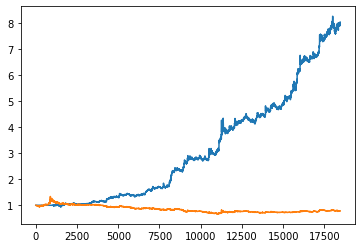

In [196]:
leg1.cumsum().apply(np.exp).plot()
leg2.cumsum().apply(np.exp).plot()

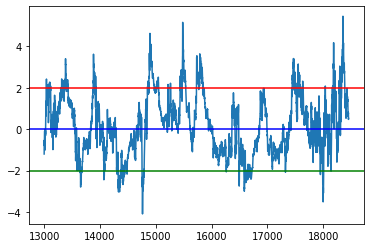

In [117]:
plt.plot(zscore.reset_index()['price'][13000:])
plt.axhline(y=2, color='r')
plt.axhline(y=-2, color='g')
plt.axhline(y=0, color='b')